In [170]:
# Instalamos lo que nos permite conectarnos a nuestro servidor mysql, asi como las librerias para graficar, matematicas y trabajar datagrames
!pip install mysql-connector-python matplotlib pandas numpy

In [171]:
# Importamos los paquetes instalados, asi como uno extra "tabulate" para obtener tablas
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

### Funcion para conectarse a una base de datos(db)

In [173]:
# Funcion que nos permite conectarnos a cualquier base de datos "db", de nuestro localhost, lo cual es posible
# ya que estamos ejecutando la libreta de manera local con jupyter
def connect_to_db(db):
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="123456",
        database=db,
    )

### Funcion para realizar una consulta(query) de una base de datos (db) y devolver los datos en un DataFrame(df) de pandas

In [175]:
# Con esta funcion podemos introducir una base de datos "db" y ejecutarle un query
# que querramos "query", devolviendonos entonces el dataframe de los datos seleccionados
def fetch_data(query,db):
    connection = connect_to_db(db)
    cursor = connection.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    cursor.close()
    connection.close()
    return df

### Preparamos nuestra base de datos en MySQL
En este caso usaremos una base de datos publica de la secretaria de salud, en la cual estan registrados los recursos.

Los datos en cuestion se encuentra en un .csv en la pagina de datos abiertos del gobierno de mexico, y al entrar a la seccion de recursos podemoes encontrarlo con el nombre de "Recursos Secretaria de Salud 2023", al descargarlo y tratar de crear una table en base a sus datos en el software personal de preferencia, en nuestro caso "MySQL Workbench" nos pregunta que columnas queremos utilizar, al haber una gran cantidad de columnas que nomas tienen una letra acompañada con numeros, sin saber que significan, nos vamos a la documentacion de la base de datos que se tiene en la pagina, donde se tiene que significa cada uno de los indices en la base de datos de interes, por lo que agregamos dicho documento excel a la base de datos local, para identificar los datos de relevancia que se quieren.

Despues de introducir y analizar los indices, 

### Query para crear una base de datos con los datos de la Secretaria de Salud
Al estar ya en nuestro entorno para ejecutar querys, escribimos:

    create database sec_sal;

## Descriptores_Recursos (excel de indices del dataframe y su significado)
Entramos al programa en linea de codigo abierto "google spreadsheets" para abrir el archivo excel que nos dice que significa cada indice del dataframe a analizar

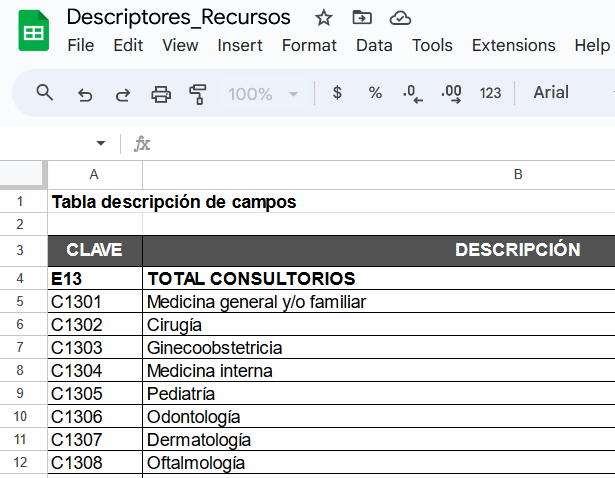

Teniendo asi las claves y lo que significan, y despues de analizarlas se concluyo que las claves que seran de interes son:(E13=total_consultorios,E18=medicos_generales_especialistas_y_odontologos,E19=personal_medico_en_adiestramiento,
E23=otro_personal_profesional,E24=personal_tecnico,E25=otro_personal) y valores especiales como lo son:
(C1750=cuenta_con_banco_de_sangre,C1706=año_estadistico), siendo el valor de casi todos numeros, con excepcion de C1750, cuyo valor es binario (1=Si, 0=No)

## Tabla con nuestro dataframe objetivo
Seleccionamos la base de datos "sec_sal" para crear una tabla con el archivo de .csv que descargamos. Utilizamos el interfaz de MySQL, mas especificamente, la herramienta que nos permite convertir archivos .csv a tablas:
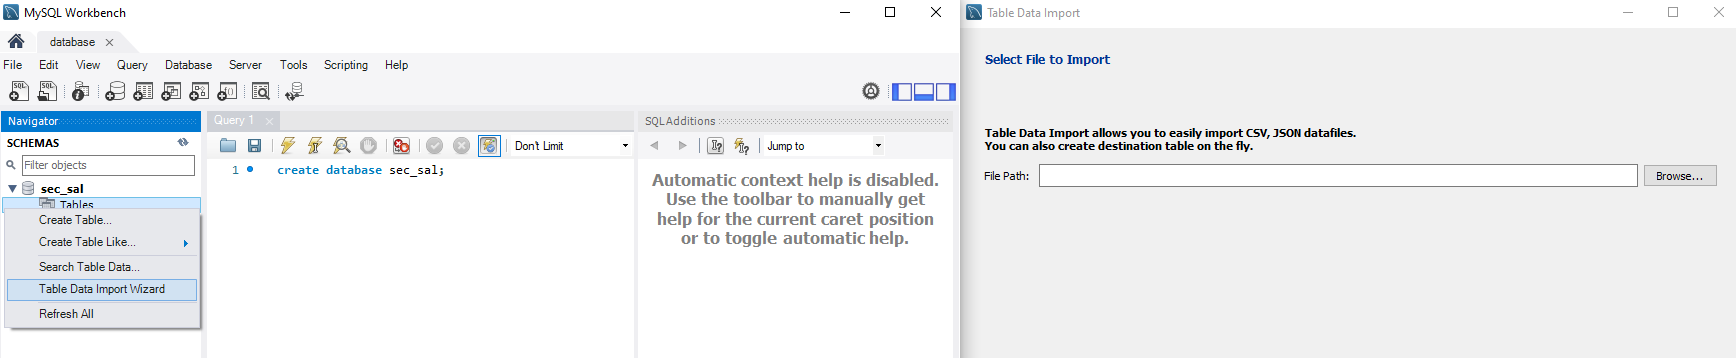

Como visto en el punto anterior, seleccionamos solos las columnas mencionadas ademas de las que si tienen descripcion completa, y consideremos prudentes
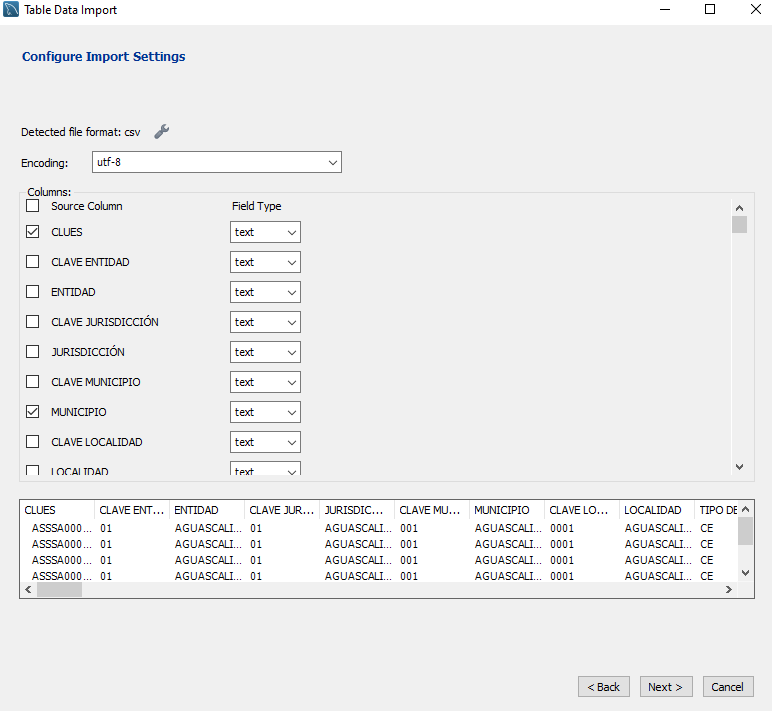

Teniendo asi la tabla con las columnas en codigo de interes, la cual puede ser consultada con el query: "select * from rec" 
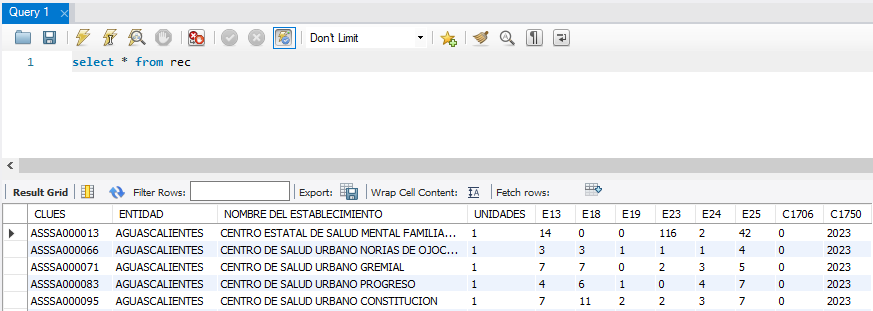

### Renombramos columnas
Lo ideal es que los nombres de las columnas sean representativos y en minusculas, entonces procedemos a cambiar los nombres de todas y a parte eliminar las columnas que despues de un analisis consideramos inecesarias'CLUES','UNIDADES','C1750'(ya que todos los datos son del 2023) con el query:
    
    ALTER TABLE `sec_sal`.`rec` 
    DROP COLUMN `UNIDADES`,
    DROP COLUMN `CLUES`,
    CHANGE COLUMN `C1750`,
    CHANGE COLUMN `ENTIDAD` `entidad` TEXT NULL DEFAULT NULL ,
    CHANGE COLUMN `NOMBRE DEL ESTABLECIMIENTO` `nombre` TEXT NULL DEFAULT NULL ,
    CHANGE COLUMN `E13` `con` INT NULL DEFAULT NULL ,
    CHANGE COLUMN `E18` `med` INT NULL DEFAULT NULL ,
    CHANGE COLUMN `E19` `mad` INT NULL DEFAULT NULL ,
    CHANGE COLUMN `E23` `pro` INT NULL DEFAULT NULL ,
    CHANGE COLUMN `E24` `tec` INT NULL DEFAULT NULL ,
    CHANGE COLUMN `E25` `otr` INT NULL DEFAULT NULL ,
    CHANGE COLUMN `C1706` `bnk` INT NULL DEFAULT NULL ,

Teniendo asi como resultado, la tabla:

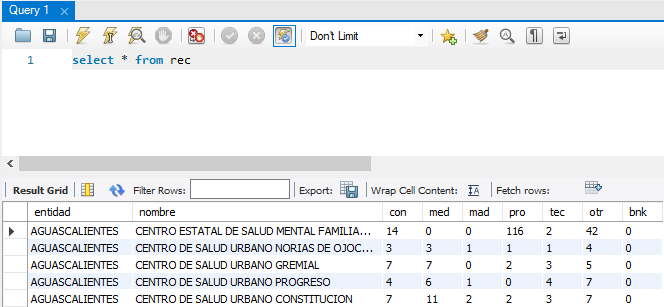

### Obtenemos un dataframe(df) de nuestra base de datos(sec_sal)
Ahora que tenemos nuestra tabla con sus datos "limpios", es solo cuestion de utilizar las funciones definidas anteriormente para conseguir un dataframe en base a sus columnas

In [199]:
query = "SELECT * FROM rec;" # Sacamos todos los datos a un dataframe
df = fetch_data(query,'sec_sal')
df.head()

,entidad,nombre,con,med,mad,pro,tec,otr,bnk
0,AGUASCALIENTES,CENTRO ESTATAL DE SALUD MENTAL FAMILIAR AGUA C...,14,0,0,116,2,42,0
1,AGUASCALIENTES,CENTRO DE SALUD URBANO NORIAS DE OJOCALIENTE,3,3,1,1,1,4,0
2,AGUASCALIENTES,CENTRO DE SALUD URBANO GREMIAL,7,7,0,2,3,5,0
3,AGUASCALIENTES,CENTRO DE SALUD URBANO PROGRESO,4,6,1,0,4,7,0
4,AGUASCALIENTES,CENTRO DE SALUD URBANO CONSTITUCION,7,11,2,2,3,7,0


### Funcion para graficar los datos de las columnas (x,y)

In [259]:
def plot_data(a,b):
    plt.xticks(rotation=90)
    plt.bar(a,b) #
    plt.xlabel('Localidades')
    plt.ylabel('Consultorios')
    plt.title('Cantidad de consultorios de 10 localidades de Sonora')
    plt.show()

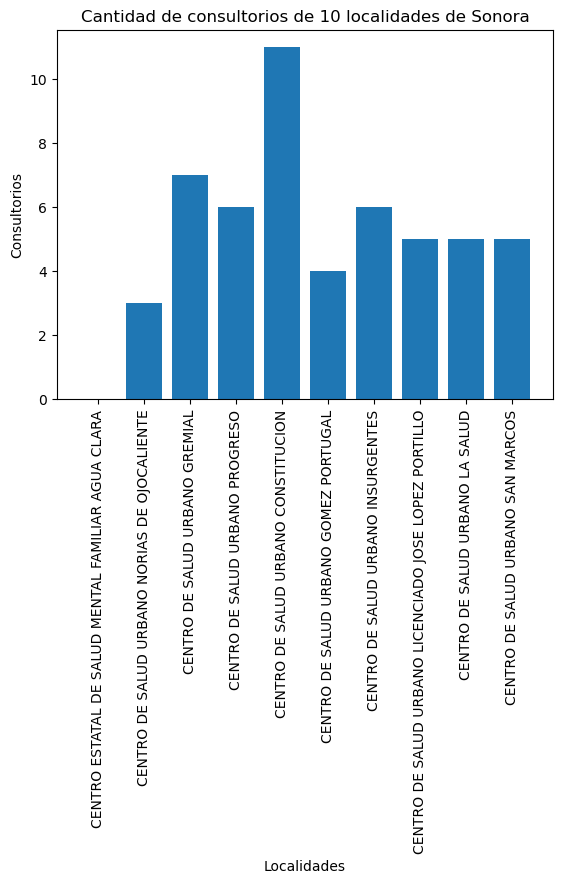

In [261]:
a='nombre'
b='med'
x=[]
y=[]
for i in range(0,10,1):
    x.append(df["nombre"][i])
    y.append(df["med"][i])
plot_data(x,y)

In [ ]:
a="entidad"
b="med"
plot_data(df,a,b)

### Funcion para imprimir los datos en forma de tabla

In [ ]:
def print_table(df):
    print(tabulate(df, headers='keys', tablefmt='psql'))

### Obtenemos todos los datos de Sonora para asi poderlos ver en una tabla

In [ ]:
query = "SELECT * FROM rec where entidad='Sonora';"
df = fetch_data(query,'sec_sal')
print_table(df)

### Se puede ver como la ultima columna no tuvo espacio y se fue al siguiente renglon, lo cual puede arreglarse de una manera quitando una de las columnas, en este caso, la columna de entidad esta sobrando, ya que especificamos que nomas queriamos los datos donde la entidad fuera Sonora, entonces quitamos esta para ver bien los numeros por nombre de hospital

In [ ]:
df = df.loc[:, df.columns != "entidad"] # Quito la columnas de nombre para poder ver bien la tabla, ya que sin esto los numeros 
print_table(df)